<a href="https://colab.research.google.com/github/rachit-shah/adbi-project/blob/master/HAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data and Glove Model From Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import nltk
nltk.download('popular')

from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, SpatialDropout1D, TimeDistributed
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Model
from keras.initializers import Constant

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import nltk.corpus
import string
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer

from keras.layers import Embedding

import time
from tensorflow import set_random_seed
set_random_seed(13)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [0]:
!cp gdrive/'My Drive'/bbc-fulltext.zip .
!cp gdrive/'My Drive'/glove.6B.zip .
!unzip bbc-fulltext.zip > out.txt
!rm bbc/README.TXT
!unzip glove.6B.zip

replace bbc/business/001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
#Read Data
categories = ['business','entertainment','politics','sport','tech']
df = pd.DataFrame([],columns=['category','id','text'])
for cat in categories:
  for file in os.listdir("bbc/"+cat):
      if file.endswith(".txt"):
          filepath = os.path.join("bbc/"+cat, file)
          text = open(filepath,'r', errors='ignore').read()
          s = pd.Series([cat,int(filepath.split('/')[-1][:-4]),text],index=['category','id','text'])
          df = df.append(s,ignore_index=True)

df.head()

,category,id,text
0,business,128,Qantas sees profits fly to record\n\nAustralia...
1,business,139,German jobless rate at new record\n\nMore than...
2,business,389,Egypt to sell off state-owned bank\n\nThe Egyp...
3,business,479,"Ford gains from finance not cars\n\nFord, the ..."
4,business,233,Bat spit drug firm goes to market\n\nA German ...


In [0]:
'''
#WordCloud
cat = df['category'].unique()

for i in range(0,len(cat)):
    words = ' '.join(df.loc[df['category']==cat[i], 'text'])

    wordcloud = WordCloud( 
                          stopwords=STOPWORDS,
                          background_color='white',
                          width=800,
                          height=400
                ).generate(words)
    print(cat[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

words = ' '.join(df.loc[:, 'text'])

wordcloud = WordCloud( 
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=800,
                      height=400
            ).generate(words)
print("ALL Categories:")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
'''

'\n#WordCloud\ncat = df[\'category\'].unique()\n\nfor i in range(0,len(cat)):\n    words = \' \'.join(df.loc[df[\'category\']==cat[i], \'text\'])\n\n    wordcloud = WordCloud( \n                          stopwords=STOPWORDS,\n                          background_color=\'white\',\n                          width=800,\n                          height=400\n                ).generate(words)\n    print(cat[i])\n    plt.figure(figsize=(10, 5))\n    plt.imshow(wordcloud)\n    plt.axis(\'off\')\n    plt.show()\n\nwords = \' \'.join(df.loc[:, \'text\'])\n\nwordcloud = WordCloud( \n                      stopwords=STOPWORDS,\n                      background_color=\'white\',\n                      width=800,\n                      height=400\n            ).generate(words)\nprint("ALL Categories:")\nplt.figure(figsize=(10, 5))\nplt.imshow(wordcloud)\nplt.axis(\'off\')\nplt.show()\n'

## Label Encoder
#### Use inverse_transform at the end after predicting

In [0]:
y = df['category']
X = df.drop(['category','id'],axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X,y,stratify=y, test_size=0.2, random_state=123)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('before: %s ...' %y_train[:5])

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train)

before: 1508       sport
1908        tech
2104        tech
2019        tech
1245    politics
Name: category, dtype: object ...
after: [3 4 4 ... 1 0 2] ...


In [0]:
print(np.bincount(y_train))
print(y.value_counts())
print(le.inverse_transform([i for i in range(5)]))

[408 309 333 409 321]
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64
['business' 'entertainment' 'politics' 'sport' 'tech']


## Preprocess Data - (split by \n, remove periods, remove slashes)

In [0]:
#Parameters for hyperparameter  tuning
dropout = 0.4
EMBEDDING_DIM = 100
traina = True #embeedding layer trainable

In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_SENT_LENGTH = 50
MAX_SENTS = 50
MAX_NB_WORDS = 20000
VALIDATION_SPLIT = 0.2
embeddings_index = {}
with open('glove.6B.'+str(EMBEDDING_DIM)+'d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
def preprocess(X):
  return X.map(lambda x: x.lower().split("\n")).map(lambda x: [y.split(". ") for y in x]).map(lambda x: [i.replace('\'','') for sl in x for i in sl if i is not ''])

In [0]:
#Preprocess both train and test separately
def replace_punct(st,punct):
  for i in punct:
    if i=="..":
      st = st.replace("..",'.')
    elif i=="--" or i == '-':
      st = st.replace(i,' ')
    else:
      st = st.replace(i,'')
  return st
punct = word_tokenize(string.punctuation) + ['``','...','..','\'s','--','-','n\'t','\'','(',')','[',']','{','}']
texts = preprocess(X_train['text']).map(lambda x: '. '.join(x)).map(lambda x: replace_punct(x,punct))
test_text = preprocess(X_test['text']).map(lambda x: '. '.join(x)).map(lambda x: replace_punct(x,punct))

In [0]:
articles = texts.map(lambda x: sent_tokenize(x))
test_articles = test_text.map(lambda x: sent_tokenize(x))

{'boxes': [<matplotlib.lines.Line2D at 0x7f3f82a49550>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3f82a49d30>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3f82a51748>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f3f82a51400>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3f82a496a0>,
  <matplotlib.lines.Line2D at 0x7f3f82a499e8>]}

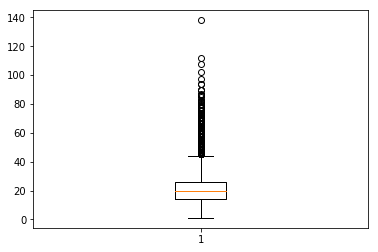

In [0]:
li = []
se = []
for x in articles:
  li.append(len(x))
  for y in x:
    se.append(len(y.split()))
  
#plt.boxplot(li,showcaps=True)
plt.boxplot(se,showcaps=True)


In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(articles):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1
                    
word_index = tokenizer.word_index
print('No. of %s unique tokens.' % len(word_index))

No. of 28415 unique tokens.


In [0]:
test_data = np.zeros((len(test_text), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(test_articles):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and word in tokenizer.word_index and tokenizer.word_index[word]<MAX_NB_WORDS:
                    test_data[i,j,k] = tokenizer.word_index[word]
                    k=k+1

In [0]:
test_data.shape

(445, 50, 50)

In [0]:
labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
np.random.seed(123)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

xtrain = data[:-nb_validation_samples]
ytrain = labels[:-nb_validation_samples]
xval = data[-nb_validation_samples:]
yval = labels[-nb_validation_samples:]

Shape of data tensor: (1780, 50, 50)
Shape of label tensor: (1780, 5)


In [0]:
'''
#Stop Words and Lemmatization   
lemmatizer = WordNetLemmatizer()
stopw = nltk.corpus.stopwords.words('english')
punct = string.punctuation
punct = word_tokenize(punct)
punct += ['.','``','...','\'s','--','-','n\'t','\'']
stopw += punct
def token_stop(text):
    global stopw
    global lemmatizer
    words = word_tokenize(text)
    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]
    return filtered
  
X_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
X_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])
'''

"\n#Stop Words and Lemmatization   \nlemmatizer = WordNetLemmatizer()\nstopw = nltk.corpus.stopwords.words('english')\npunct = string.punctuation\npunct = word_tokenize(punct)\npunct += ['.','``','...',''s','--','-','n't',''']\nstopw += punct\ndef token_stop(text):\n    global stopw\n    global lemmatizer\n    words = word_tokenize(text)\n    filtered = [lemmatizer.lemmatize(w) for w in words if not w in stopw]\n    return filtered\n  \nX_train['text'] = X_train['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])\nX_test['text'] = X_test['text'].map(lambda x: [token_stop(i) for i in x]).map(lambda x: [i for sl in x for i in sl])\n"

In [0]:
#Create glove embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
#Map label name to its index
labels_index = {}
for i in range(5):
  name = le.inverse_transform([i])[0]
  labels_index[name] = i
labels_index

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

## Train Model

In [0]:
#Keras Glove Embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=traina)

In [0]:
model_name = "HAN-"+str(dropout)+"-"+str(EMBEDDING_DIM)+"-Trainable-"+traina
checkpointer = ModelCheckpoint(model_name + "_weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor="val_loss", verbose=1,
                               save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tensorboard_han = TensorBoard(log_dir='./Graph_HAN', histogram_freq=1,write_graph=True,write_grads=True, write_images=True)

In [0]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_layer = Bidirectional(LSTM(100,dropout=dropout))(embedded_sequences)
sentEncoder = Model(sentence_input, lstm_layer)

article_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
article_encoder = TimeDistributed(sentEncoder)(article_input)
lstm_layer_sent = Bidirectional(LSTM(100,dropout=dropout))(article_encoder)
preds = Dense(len(labels_index), activation='softmax')(lstm_layer_sent)
han_model = Model(article_input, preds)

han_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
han_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 50, 50)            0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 50, 200)           3002400   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 1005      
Total params: 3,244,205
Trainable params: 402,605
Non-trainable params: 2,841,600
_________________________________________________________________


In [0]:
stmillis = int(round(time.time() * 1000))
history = han_model.fit(xtrain, ytrain, validation_data=(xval, yval),
          epochs=50, batch_size=128, callbacks=[checkpointer, early_stopping])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Train on 1424 samples, validate on 356 samples
Epoch 1/50
1424/1424 [==============================] - 40s 28ms/step - loss: 1.4193 - acc: 0.4249 - val_loss: 0.8622 - val_acc: 0.6770

Epoch 00001: val_loss improved from inf to 0.86216, saving model to HAN_weights.01-0.86.hdf5
Epoch 2/50
1424/1424 [==============================] - 7s 5ms/step - loss: 0.8813 - acc: 0.7093 - val_loss: 0.4121 - val_acc: 0.8399

Epoch 00002: val_loss improved from 0.86216 to 0.41210, saving model to HAN_weights.02-0.41.hdf5
Epoch 3/50
1424/1424 [==============================] - 7s 5ms/step - loss: 0.4330 - acc: 0.8862 - val_loss: 0.9080 - val_acc: 0.7051

Epoch 00003: val_loss did not improve from 0.41210
Epoch 4/50
1424/1424 [==============================] - 7s 5ms/step - loss: 0.4192 - acc: 0.8638 - val_loss: 0.3831 - val_acc: 0.8652

Epoch 00004: val_loss improved from 0.41210 to 0.38315, saving model to HAN_weights.04-0.38.hdf5
Epoch 5/50
1424/1424 [==============================] - 7s 5ms/step - los

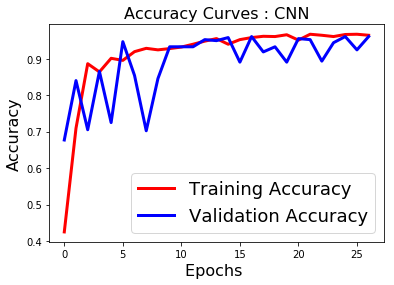

In [0]:
fig=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig.savefig('accuracy_cnn.png')
plt.show()

In [0]:
# Save the trained weights
han_model.save(model_name + ".h5")

# Save model config as json
model_json = han_model.to_json()
with open(model_name + ".json", "w") as json_file:
    json_file.write(model_json)

# Persist the model to your google drive [VERY IMPORTANT]
!cp HAN.* gdrive/My\ Drive/

In [0]:
test_data.shape

(445, 50, 50)

## Predict on Test Data

In [0]:
def find_test_acc(prediction):
  count = 0
  t = 0
  for pred in prediction:
    p = pred.argmax()
    name = le.inverse_transform([p])
    #print(count)
    #print(y_test.loc[count])
    if name == y_test.loc[count]:
      t+=1
    count+=1
  print('Test Accuracy:',(t/count)*100,"%")

In [0]:
def predict_test(model):
  prediction = model.predict(test_data)
  find_test_acc(prediction)

In [0]:
predict_test(han_model)

Test Accuracy: 96.40449438202248 %


## Tensorboard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-05-02 00:26:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.60.111, 52.72.245.79, 52.7.169.168, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.60.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14991793 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  14.30M  62.3MB/s    in 0.2s    

2019-05-02 00:26:02 (62.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [14991793/14991793]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
LOG_DIR = './Graph_HAN'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://f759b158.ngrok.io


In [0]:
!ls

accuracy_cnn.png	  HAN_weights.08-0.25.hdf5
bbc			  HAN_weights.08-1.18.hdf5
bbc-fulltext.zip	  HAN_weights.09-0.17.hdf5
gdrive			  HAN_weights.09-1.14.hdf5
glove.6B.100d.txt	  HAN_weights.11-0.16.hdf5
glove.6B.200d.txt	  HAN_weights.11-0.22.hdf5
glove.6B.300d.txt	  HAN_weights.11-1.12.hdf5
glove.6B.50d.txt	  HAN_weights.12-0.15.hdf5
glove.6B.zip		  HAN_weights.12-0.19.hdf5
HAN.h5			  HAN_weights.12-1.10.hdf5
HAN.json		  HAN_weights.13-0.13.hdf5
HAN_weights.01-0.82.hdf5  HAN_weights.13-0.15.hdf5
HAN_weights.01-0.92.hdf5  HAN_weights.14-0.12.hdf5
HAN_weights.01-0.95.hdf5  HAN_weights.14-0.13.hdf5
HAN_weights.01-1.61.hdf5  HAN_weights.16-0.13.hdf5
HAN_weights.02-0.45.hdf5  HAN_weights.16-1.02.hdf5
HAN_weights.02-0.47.hdf5  HAN_weights.19-0.92.hdf5
HAN_weights.02-0.58.hdf5  HAN_weights.23-0.12.hdf5
HAN_weights.02-1.59.hdf5  HAN_weights.23-0.91.hdf5
HAN_weights.03-0.53.hdf5  HAN_weights.24-0.10.hdf5
HAN_weights.04-0.32.hdf5  HAN_weights.25-0.10.hdf5
HAN_weights.04-0.44.hdf5  HAN_weights.30